In [45]:
import numpy as np
import matplotlib.pyplot as plt

# generate 'data' (artificial experiment) from function $g(x)=(\frac{1}{2}+tan(\frac{\pi}{2}x))^2$(which is precise value)  
with relative error of each 'experimental points' being constant $c$  
the number of mesh (or $x$ points) $N$

In [46]:
# precise curve g(x) used to generate the data
def g(x):
    return (0.5 + np.tan(np.pi * x / 2))**2

# number of x mesh points N
N=10

# relative error at each x point being constant c
c=0.05

generate mesh $x$ within domain $D_2=[0,\frac{2}{\pi}]$, $N$ points  (mean mesh)

In [47]:
x=np.linspace(2/np.pi/N,2/np.pi,N)

$\eta$ is used to generate 'experiment data' (virtually or artificially), which follows a normal distribution, for each data point there is a corresponding $\sigma_{\eta_i}$    
$\sigma_{\eta}=1,\bar{\eta}=0$, $\eta \sim N(0,\sigma_\eta)$  
then generate 'data points' by $y(x_i)=g(x_i)(1+c\eta_i)$  
and $\sigma_i=cy(x_i)$

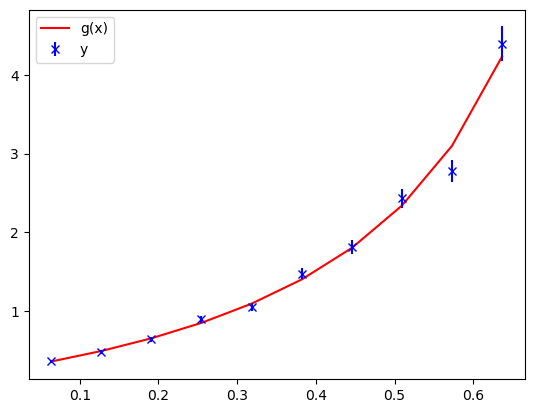

In [48]:
# eta_i, N times correpsonding to N x mesh points
sigma_eta=1
eta=np.random.normal(0,sigma_eta,N)
y=g(x)*(1+c*eta)
sigma=c*y
#--------------------------------------------
plt.plot(x,g(x),'r-',label='g(x)')
plt.errorbar(x,y,yerr=sigma,fmt='bx',label='y')
plt.legend()
plt.show()

# Select model: order of polynominal $M$, define polynominal function, i.e. 'model', define Prior, Likelihood, Posterior
 
Prior:  
$$ prior(\vec{a}|M,R)=(\frac{1}{\sqrt{2\pi}R})^{M+1}exp(-\frac{\vec{a}^2}{2R^2}) $$

Likelihood:
$$
likelihood(D|\boldsymbol{a})\propto exp(-\frac{1}{2}\sum_{i}(\frac{y_i-f_i}{\sigma_i})^2)
$$

Posterior:
$$
posterior(\boldsymbol{a}|D)\propto exp(-\frac{1}{2}(\sum_{i}(\frac{y_i-f_i}{\sigma_i})^2+\frac{\boldsymbol{a}^2}{R^2}))
$$

$R$: standard deviation parameter in the prior 

sample parameter ($(M+1)$ rows, $N_{sampling}$ columns)  


chi square: $\chi^2=\sum_{i} \frac{(y_i-f_i)^2}{\sigma_i^2} $  
likelihood: $p(D|\alpha)\propto exp(-\frac{1}{2}\chi^2)$


In [50]:
#def polynomial function, i.e. 'model'
def polynomial(para,x):
    return np.polyval(para,x)

#def chi-square function
def chi_square(y, f, sigma):
    return np.sum(((y-f)**2)/sigma**2)

#def likelyhood function
def likelihood(y, f, sigma):
    chi_sq = chi_square(y, f, sigma)
    return np.exp(-0.5 * chi_sq)
    
#def log_posterior
def log_posterior(a, x, y, sigma, R):
    model = polynomial(a, x)  
    return -0.5 * (np.sum(a**2)/ R**2 + chi_square(y, model, sigma))

order of polynomiall M and standard deviation parameter R in prior

In [49]:
M=5
R=5

# use emcee to carry out mcmc samping which submit to the posterior distribution

number of mcmc walkers: nwalkers  
initialize parameter vector $\vec{a}$, with size [nwalkers , (M+1)]  
obey the prior distribution  
because there are nwalkers walkers required to be initialized parallelly

In [51]:
nwalkers = 32   
a = np.random.normal(0, R, (nwalkers, M+1))

the last argument of sampler should exclude those 'actual' parameter vector $\vec{a}$,  
which only includes input x, data y, and those 'hyperparameter' in prior function $\sigma$,R  
with number of burn-in step being 1000 or other number restored in state  
then we formally start mcmc sampling   

In [52]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, M+1, log_posterior, args=[x,y,sigma,R],a=4)
state = sampler.run_mcmc(a, 1000)
sampler.reset()
sampler.run_mcmc(state, 10000);

# Use corner (in prettyplease or not) to visualize the samping and results

all the sampling in one figure

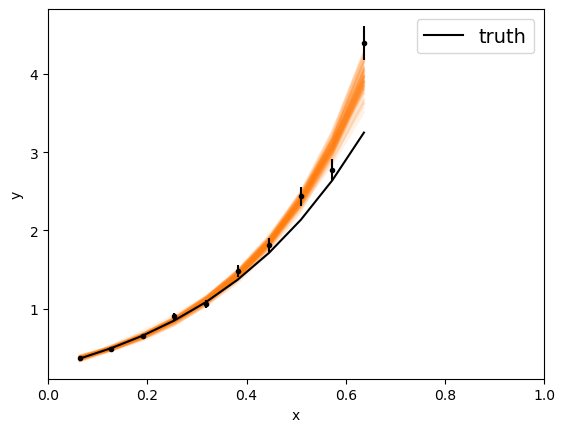

In [53]:
import corner

samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(samples), size=100)
for ind in inds:
    sample = samples[ind]
    plt.plot(x, np.polyval(sample,x), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=sigma, fmt=".k", capsize=0)
plt.plot(x, np.polyval([4.06,1.29,2.47,1.57,0.25],x), "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel("y");

## posterior of parameters, and each 2 parameters marginal posterior distribution (covariance), with prettyplease.corner

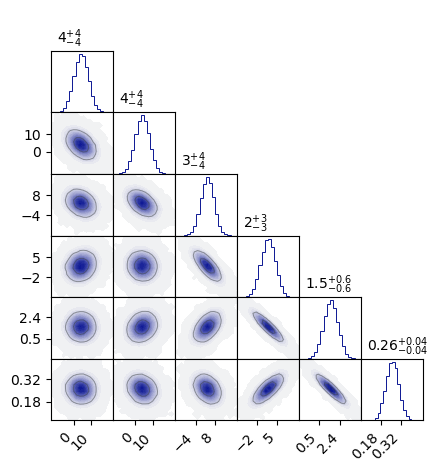

In [59]:
import prettyplease
samples = sampler.get_chain(flat=True)
# plt.hist(samples[:,3], 100, color="k", histtype="step", density=True)
# plt.xlabel(r"$\theta$")
# plt.ylabel(r"$p(\theta|D)$")
#plt.gca().set_yticks([]);
fig = prettyplease.corner(samples)
plt.show()  

## model results within $2\sigma$ (16% -> 50% -> 84%)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\16437\AppData\Local\Temp\ipykernel_15156\178486562.py:14: SyntaxWarning: invalid escape sequence '\m'


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(320000, 10)


Text(0, 0.5, 'Values')

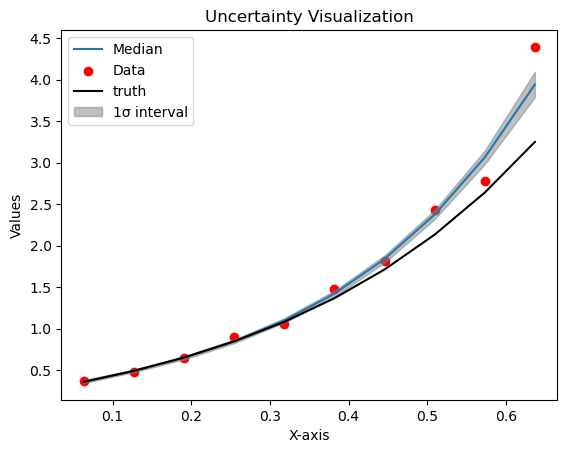

In [57]:
from IPython.display import display, Math

# para's label & median value and 1 sigma interval

labels = [f'a{i}' for i in range(M, -1, -1)]

# print the median value and 1 sigma interval

for i in range(M+1):
    mcmc1 = np.percentile(samples[:, i], [16, 50, 84])
    q1= np.diff(mcmc1)
    
    perc16[i], median[i], perc84[i] = mcmc1
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc1[1], q1[0], q1[1], labels[i])
    display(Math(txt))

#MODEL prediction in 1 sigma interval

#initialize the model result: result_samples array
result_samples=np.zeros((len(samples),len(x)))
q=np.zeros(len(x))
median = np.zeros(len(x))
perc16 = np.zeros(len(x))
perc84 = np.zeros(len(x))

#------------------------------------------------

for i in range(len(samples)):
    result_samples[i]=np.polyval(samples[i],x)

print(result_samples.shape)

for i in range(len(x)):
    mcmc = np.percentile(result_samples[:, i], [16, 50, 84])
    q= np.diff(mcmc)
    
    perc16[i], median[i], perc84[i] = mcmc

########################################################################################

plt.plot(x, median, label='Median')   
plt.scatter(x, y, color='r', label='Data') 
plt.plot(x, np.polyval([4.06,1.29,2.47,1.57,0.25],x), "k", label="truth")
plt.fill_between(x, perc16, perc84, color='gray', alpha=0.5, label='1σ interval')

#label and title
plt.legend()
plt.title('Uncertainty Visualization')
plt.xlabel('X-axis')
plt.ylabel('Values')


In [ ]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)